In [48]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from joblib import dump
from matplotlib import pyplot as plt


In [49]:
dataX = np.loadtxt("../preprocessed_data/dataX.csv", delimiter=",")
dataY = np.loadtxt("../preprocessed_data/dataY.csv", delimiter=",")

trainX = np.loadtxt("../preprocessed_data/trainX.csv", delimiter=",")
trainY = np.loadtxt("../preprocessed_data/trainY.csv", delimiter=",")

testX = np.loadtxt("../preprocessed_data/testX.csv", delimiter=",")
testY = np.loadtxt("../preprocessed_data/testY.csv", delimiter=",")

dataX.shape, dataY.shape, trainX.shape, trainY.shape, testX.shape, testY.shape


((3015, 13), (3015,), (2680, 13), (2680,), (335, 13), (335,))

In [50]:
scaler = StandardScaler()

scaler.fit(dataX)

trainX = scaler.transform(trainX)
testX = scaler.transform(testX)

dump(scaler, "std_scaler.joblib")


['std_scaler.joblib']

In [51]:
class SensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, ix):
        x = self.X[ix]
        y = self.y[ix]
        return x, y
    
    def get_all(self):
        return self.X, self.y
    
train_set = SensorDataset(trainX, trainY)
test_set = SensorDataset(testX, testY)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden1 = 64
hidden2 = 32

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(trainX.shape[1], hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.layers(x)
    
model = MLP().to(device)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [53]:
epochs = 6
losses = []

model.train()
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    for batch_num, input_data in enumerate(train_loader):
        optimizer.zero_grad()
        x, y = input_data
        x = x.to(device).float()
        y = y.to(device).float().view(-1, 1)

        output = model(x)
        
        loss = loss_function(output, y)
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        
        if batch_num % 10 == 0:
            print(f"Loss: {loss.item() ** 0.5}")

        

Epoch 1/6
Loss: 7.207568471677933
Loss: 6.2488661691268605
Loss: 6.2823767718955486
Loss: 5.533191404858749
Loss: 4.570513024780958
Loss: 3.7519475330189977
Loss: 2.8913602976328527
Loss: 3.0113138799989803
Loss: 2.4067683466656526
Epoch 2/6
Loss: 2.2217447191718422
Loss: 1.806117560471198
Loss: 2.2500466235946335
Loss: 1.8626651025086054
Loss: 1.6184801473263206
Loss: 1.393428120415776
Loss: 1.4132917210837868
Loss: 1.3697710313681057
Loss: 1.1912688129136373
Epoch 3/6
Loss: 1.028600699806754
Loss: 1.1969226638426624
Loss: 1.1306895917552915
Loss: 1.1786197604966027
Loss: 0.9355476076764322
Loss: 0.8883719472622006
Loss: 0.9327811371660303
Loss: 0.6664682679202535
Loss: 0.7502515688825434
Epoch 4/6
Loss: 1.0186020866622838
Loss: 0.9269404497658462
Loss: 0.7799473010502818
Loss: 0.6680490991999039
Loss: 0.605248885073732
Loss: 0.6202977435761424
Loss: 0.9316260378673263
Loss: 0.746422580335123
Loss: 0.6097129471560264
Epoch 5/6
Loss: 0.7662142607426976
Loss: 0.3897581400165001
Loss: 0.

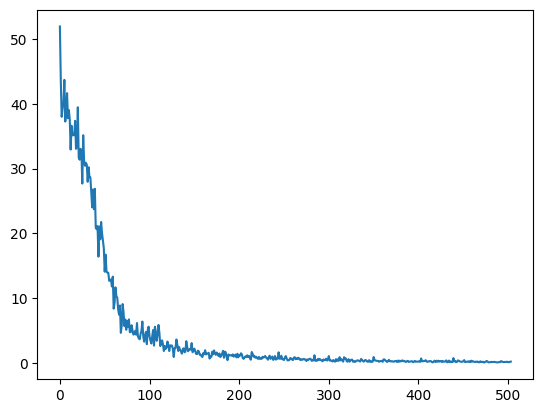

In [54]:
plt.plot(losses)

In [55]:
model.eval()

test_X, test_y = test_set.get_all()

test_predictions = model(test_X)

loss = loss_function(test_predictions, test_y.view(-1, 1))

print(f"Test loss: {loss.item() ** 0.5}")


Test loss: 0.8685421372526203
